<a href="https://colab.research.google.com/github/Lokuhu/112-2_2LNN/blob/main/%E5%9B%9BD56_HW4_LG_UA%E5%8A%A0r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Weight-tuning by Learning Goal or Undesired Attractor**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
# 試算表>檔案>共用>發布到網路 即可於colab中讀取
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQhbAejyGUXlZltX2nsbC4sTw890L6081piAP8ZDJVbufqZ9xm-S5P7gIrXnpgszm-U9SmEkBxJc5uF/pub?gid=1265524659&single=true&output=csv'
seed = pd.read_csv(url)

In [ ]:
seed['Type'] = seed['Type'].replace(1, 0.0)
seed['Type'] = seed['Type'].replace(2, 1.0)
seed['Type'] = seed['Type'].replace(3, 2.0)
seed

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,2
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,2


In [ ]:
# Split data
X = seed.drop('Type',axis=1).values
y = seed['Type'].values

# 20%test, 80%training
X_train, X_test, y_train, y_test=train_test_split (X, y ,test_size = 0.2, random_state = 30)

# Covert X and y to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Model5 (the best performance on accuracy)

In [ ]:
#hidden nodes = 11 (change to 9), activation function = Tanh, Optimizer = SGD, learning epochs = 300, learning rate = 0.01, momentum = 0.9
class Model5(nn.Module):

    def __init__(self, in_features = 7, h1 = 9, out_features = 3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # Use tanh activation
        x = torch.tanh(self.out(x))  # Use tanh activation

        return x

model5 = Model5()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model5.parameters(),lr=0.07) # original lr is 0.01

In [ ]:
model5

Model5(
  (fc1): Linear(in_features=7, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [ ]:
#Train the model5
epochs = 300
error_threshold = 0.01
lr = 0.01

losses = []

# regularization
l2_lambda = 0.001
p = 7  # 輸入特徵數
m = 11  # 隱藏層節點數
regularization_term = (l2_lambda / (p + 1 + p * (m + 1))) * sum(p.pow(2.0).sum() for p in model5.parameters()) # CH8的數學公式


for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model5(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if loss.item() < error_threshold:
        print(f'Stopping early at epoch {epoch}, loss: {loss.item()}')
        break

    # Weight adjustment
    optimizer.zero_grad()
    y_pred = model5(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # Is adjusted weight accepted ? (UA)
    if loss.item() < criterion(model5(X_train), y_train):
        lr *= 1.2
    else:
        if lr > error_threshold:
            print("Unacceptable 2LNN, stopping training.")
            break
        lr *= 0.7
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

Unacceptable 2LNN, stopping training.


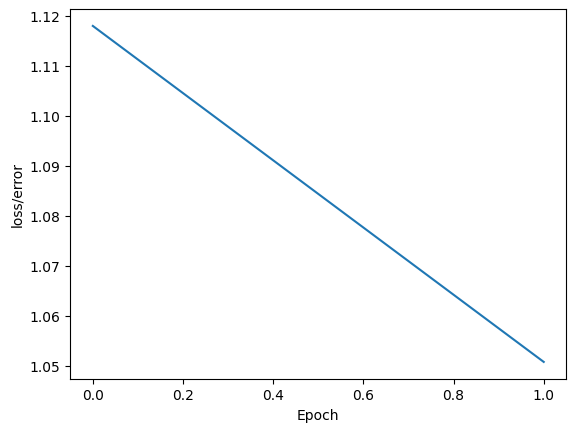

In [ ]:
plt.plot(range(len(losses)),losses)
plt.ylabel('loss/error')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Evaluate Model on test dataset (validation model1 on test set)
with torch.no_grad():
    correct = 0
    for i, data in enumerate(X_test):
        y_val = model5.forward(data)
        print(f'{i+1}. {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'Number of correct predictions: {correct}/{len(y_test)}')
    print(f'Accuracy: {correct/len(y_test)}')


1. tensor([-0.3544,  0.0250, -0.3554]) 	 1 	 1
2. tensor([-0.3245, -0.1560, -0.2864]) 	 2 	 1
3. tensor([-0.2806, -0.2369, -0.2471]) 	 2 	 1
4. tensor([-0.3544,  0.0788, -0.3883]) 	 1 	 1
5. tensor([-0.3363,  0.0413, -0.3686]) 	 0 	 1
6. tensor([-0.3130, -0.1513, -0.2832]) 	 2 	 1
7. tensor([-0.3369, -0.0377, -0.3237]) 	 0 	 1
8. tensor([-0.3370,  0.0056, -0.3463]) 	 0 	 1
9. tensor([-0.2607, -0.2894, -0.2308]) 	 2 	 2
10. tensor([-0.3852,  0.0763, -0.3744]) 	 1 	 1
11. tensor([-0.3471,  0.0505, -0.3700]) 	 0 	 1
12. tensor([-0.3789,  0.0939, -0.3861]) 	 1 	 1
13. tensor([-0.3703,  0.0470, -0.3633]) 	 1 	 1
14. tensor([-0.3543,  0.0541, -0.3711]) 	 0 	 1
15. tensor([-0.2528, -0.2780, -0.2280]) 	 2 	 2
16. tensor([-0.3198, -0.0524, -0.3186]) 	 2 	 1
17. tensor([-0.2813, -0.1765, -0.2693]) 	 2 	 1
18. tensor([-0.2935, -0.2838, -0.2475]) 	 2 	 2
19. tensor([-0.3448,  0.0084, -0.3461]) 	 0 	 1
20. tensor([-0.2866, -0.2360, -0.2547]) 	 2 	 1
21. tensor([-0.2934, -0.0688, -0.3087]) 	 2 	 1
2

In [ ]:
loss

tensor(1.1111, grad_fn=<NllLossBackward0>)

In [ ]:
correct=0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model5.forward(data)

        print(f'{i+1}. {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

        if y_val.argmax().item() == y_test[i]:
            correct+=1
print(f'we got {correct} correct!')
print(f'the accuracy is {correct/len(y_test)}')

1. tensor([-0.3544,  0.0250, -0.3554]) 	 1 	 1
2. tensor([-0.3245, -0.1560, -0.2864]) 	 2 	 1
3. tensor([-0.2806, -0.2369, -0.2471]) 	 2 	 1
4. tensor([-0.3544,  0.0788, -0.3883]) 	 1 	 1
5. tensor([-0.3363,  0.0413, -0.3686]) 	 0 	 1
6. tensor([-0.3130, -0.1513, -0.2832]) 	 2 	 1
7. tensor([-0.3369, -0.0377, -0.3237]) 	 0 	 1
8. tensor([-0.3370,  0.0056, -0.3463]) 	 0 	 1
9. tensor([-0.2607, -0.2894, -0.2308]) 	 2 	 2
10. tensor([-0.3852,  0.0763, -0.3744]) 	 1 	 1
11. tensor([-0.3471,  0.0505, -0.3700]) 	 0 	 1
12. tensor([-0.3789,  0.0939, -0.3861]) 	 1 	 1
13. tensor([-0.3703,  0.0470, -0.3633]) 	 1 	 1
14. tensor([-0.3543,  0.0541, -0.3711]) 	 0 	 1
15. tensor([-0.2528, -0.2780, -0.2280]) 	 2 	 2
16. tensor([-0.3198, -0.0524, -0.3186]) 	 2 	 1
17. tensor([-0.2813, -0.1765, -0.2693]) 	 2 	 1
18. tensor([-0.2935, -0.2838, -0.2475]) 	 2 	 2
19. tensor([-0.3448,  0.0084, -0.3461]) 	 0 	 1
20. tensor([-0.2866, -0.2360, -0.2547]) 	 2 	 1
21. tensor([-0.2934, -0.0688, -0.3087]) 	 2 	 1
2